In [7]:
%cd "~/flex-limits"

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pyomo.environ import *
from models.flexload_milp import flexloadMILP


/home/akshay/flex-limits


AttributeError: module 'electric_emission_cost.units' has no attribute 'USD'

## Read the emissions data

We are using marginal emissions per region averaged by month and hour. 

In [2]:
regions= ["CAISO", "ERCOT", "ISONE", "MISO", "NYISO", "PJM", "SPP"]

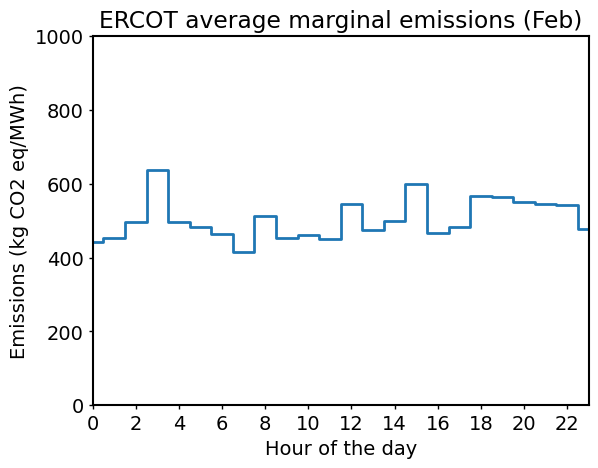

In [3]:
# read the data
region = 'ERCOT'
data = pd.read_csv('~/electricity-carbon-cost/data/average_MEFs/'+region+'emissions.csv')
month=2
data.head()

month_to_str = {1:'Jan',
                2:'Feb',
                3:'Mar',
                4:'Apr',
                5:'May',
                6:'Jun',
                7:'Jul',
                8:'Aug',
                9:'Sep',
                10:'Oct',
                11:'Nov',
                12:'Dec'}

# subset data based on the month
co2i = data[data['month'] == month]['co2_eq_kg_per_MWh']

# plot the data make the ticks on the outside
plt.rcParams.update({'font.size': 14,
                     'axes.linewidth': 1.5,
                     'lines.linewidth': 2,
                     'lines.markersize': 6,
                     'xtick.major.size': 3,
                     'xtick.major.width': 1,
                     'ytick.major.size': 3,
                     'ytick.major.width': 1,
                     'xtick.direction': 'out',
                     'ytick.direction': 'out',})  

fig, ax = plt.subplots()
ax.step(range(len(co2i)), co2i, where='mid')
ax.set(xlabel='Hour of the day', 
       ylabel='Emissions (kg CO2 eq/MWh)',
       title=region+' average marginal emissions (' + str(month_to_str[month])+')',
       xticks=range(0, len(co2i), 2),
       xlim=(0, len(co2i)-1), 
       ylim=(0, 1000))
plt.show()

In [4]:
(np.mean(co2i) - np.min(co2i))/np.mean(co2i)

0.17411928873467997

## Calculate the maximum possible emissions savings from flexibility

In an idealized case, let's consider a system that normally operates at a constant power consumption but can choose the hours in the day to be on - all other hours are completely off. The maximum emissions savings occurs during the hours with the minimum emissions intensity. 

Here, we calculate the upper bound on emissions savings from this type of flexibility. This is only applicable to pure energy consumers that operate nearly in steady state, not systems that also produce energy or have naturally peaky loads. 

Solver termination condition:  optimal
Model constructed in:  0.01133418083190918
Model solved in:  0.05188107490539551
Total time:  0.06321525573730469

------------------------
	Baseline: 12076.61 kgCO2/MWh
	Flexible: 10717.18 kgCO2/MWh
	Savings: 11.26%
------------------------


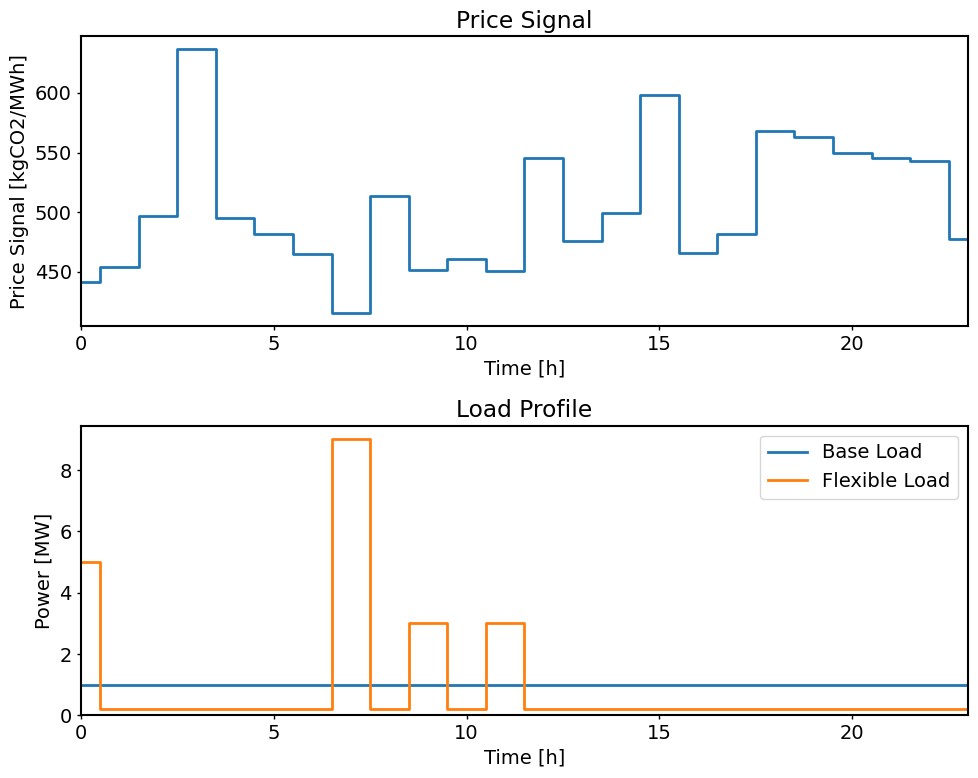

In [13]:
baseload_flat = np.ones(len(co2i))
flex = flexloadMILP(baseload=baseload_flat, 
                    pricesignal=co2i.tolist(), 
                    flex_capacity=0.5, 
                    rte=1.0, 
                    min_onsteps=4,
                    min_shutdowns=None,
                    non_sheddable_fraction=0.2,
                    pricesignal_units='kgCO2/MWh')
model = flex()

Let's look at how the emissions savings potential varies by month. Note, this is an upper bound since it assumes there are 0 efficiency losses associated with energy flexibility and the system can shut down and turn back online instantly any number of times within the horizon. 

In [14]:
month_arr = np.arange(1, 13)
min_onsteps_arr = np.arange(1, 24)
baseload_flat = np.ones(24)

# # create a meshgrid and compute pct_savings
X, Y = np.meshgrid(month_arr, 100 * min_onsteps_arr/max(min_onsteps_arr))
pct_savings = np.zeros(X.shape)

for i in range(len(month_arr)):
    for j in range(len(min_onsteps_arr)):
        co2i = data[data['month'] == month_arr[i]]['co2_eq_kg_per_MWh']
        
        flex = flexloadMILP(baseload=baseload_flat, 
                            pricesignal=co2i.tolist(), 
                            flex_capacity=0.0, 
                            rte=1.0, 
                            min_onsteps=min_onsteps_arr[j],
                            min_shutdowns=None)
        flex.build()
        flex.solve()
        pct_savings[j, i] = flex.model.pct_savings()

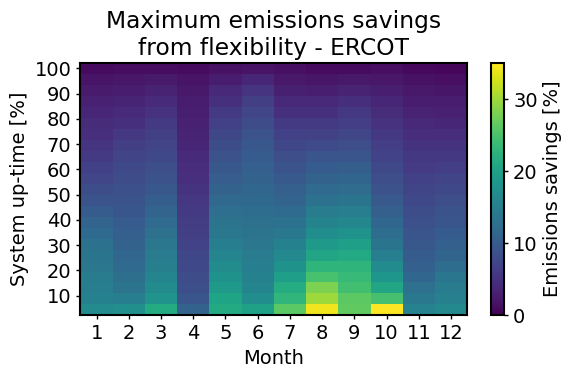

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
c = ax.pcolormesh(X, Y, pct_savings, cmap='viridis', vmin=0, vmax=35)
ax.set(xlabel='Month', 
        ylabel='System up-time [%]', 
        title='Maximum emissions savings\nfrom flexibility - '+region,
        xticks=month_arr,
        yticks= np.arange(10, 101, 10))
fig.colorbar(c, ax=ax, label='Emissions savings [%]')
fig.tight_layout()

## Energy flexibility parameters

The potential savings get worse when we consider the additional energy consumed by flexible operations (e.g. start up/shutdown, out of BEP operation, etc.) and limit the production window to be continuous (e.g. 1 shutdown per day).

In [16]:
co2i = data[data['month'] == month]['co2_eq_kg_per_MWh']
min_onsteps_arr = np.arange(1, 25)
rte_arr = np.arange(0.9, 1.025, 0.025).round(3)
# # create a meshgrid and compute pct_savings
min_onsteps_mesh, rte_mesh = np.meshgrid(min_onsteps_arr, rte_arr)
pct_savings_oneshutdown = np.zeros(min_onsteps_mesh.shape)
pct_savings_multishutdown = np.zeros(min_onsteps_mesh.shape)

for i in range(len(min_onsteps_arr)):
    for j in range(len(rte_arr)):
        flex = flexloadMILP(baseload=baseload_flat, 
                    pricesignal=co2i.tolist(), 
                    flex_capacity=0.0, 
                    rte=rte_arr[j], 
                    min_onsteps=min_onsteps_arr[i],
                    min_shutdowns=1)
        flex.build()
        flex.solve()
        pct_savings_oneshutdown[j, i]= flex.model.pct_savings()

        # flex = flexloadMILP(baseload=baseload_flat, 
        #     pricesignal=co2i.tolist(), 
        #     flex_capacity=0.0, 
        #     rte=rte_arr[j], 
        #     min_onsteps=min_onsteps_arr[i],
        #     min_shutdowns=None)
        # flex.build()
        # flex.solve()
        # pct_savings_multishutdown[j, i]= flex.model.pct_savings()

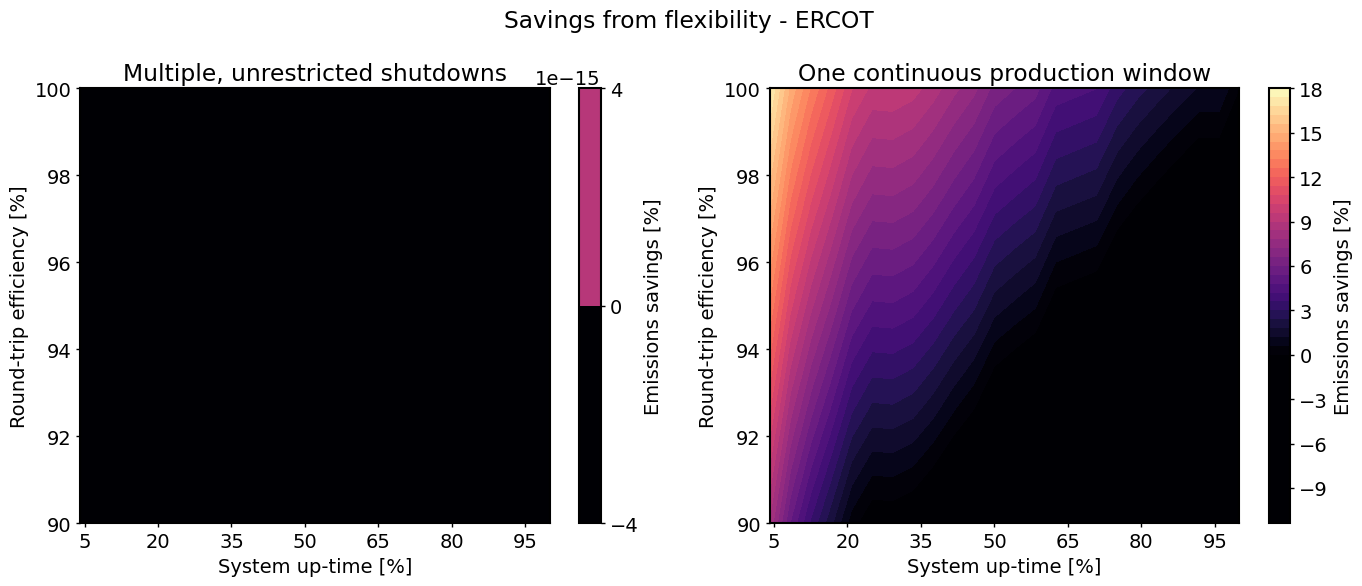

In [17]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
cs0 = ax[0].contourf(100 * min_onsteps_mesh / max(min_onsteps_arr), rte_mesh*100, pct_savings_multishutdown, levels=50,vmin=0,cmap='magma')
cbar0 = fig.colorbar(cs0)
cbar0.set_label('Emissions savings [%]')
ax[0].set(xlabel='System up-time [%]', 
       ylabel='Round-trip efficiency [%]',
       title='Multiple, unrestricted shutdowns',
       xticks=np.arange(5, 100, 15),
       facecolor='k')
       

cs1 = ax[1].contourf(100 * min_onsteps_mesh / max(min_onsteps_arr), rte_mesh*100, pct_savings_oneshutdown, levels=50,vmin=0,cmap='magma')
cbar1 = fig.colorbar(cs1)
cbar1.set_label('Emissions savings [%]')
ax[1].set(xlabel='System up-time [%]', 
       ylabel='Round-trip efficiency [%]',
       title='One continuous production window', 
       xticks=np.arange(5, 108, 15),
       facecolor='k')

fig.suptitle('Savings from flexibility - '+region)
fig.tight_layout()

Achieving the maximum potential emissions savings also requires the model to have a very up-flex power capacity and large relative discharge capacity. 

In [18]:
min_onsteps_arr = np.arange(1, 25)
flex_capacity_arr = np.arange(0.1, 0.95, 0.05)

# # create a meshgrid and compute energy capacity and power capacity
min_onsteps_mesh, flex_capacity_mesh = np.meshgrid(min_onsteps_arr, flex_capacity_arr)
upflex_pc = np.zeros(min_onsteps_mesh.shape)
discharge_ec = np.zeros(min_onsteps_mesh.shape)

for i in range(len(min_onsteps_arr)):
    for j in range(len(flex_capacity_arr)):
        flex = flexloadMILP(baseload=baseload_flat, 
                    pricesignal=co2i.tolist(), 
                    flex_capacity=flex_capacity_arr[j], 
                    rte=1.0, 
                    min_onsteps=min_onsteps_arr[i],
                    min_shutdowns=None)
        flex.build()
        flex.solve()
        upflex_pc[j, i], discharge_ec[j, i] = flex.calc_metrics(flex.model)

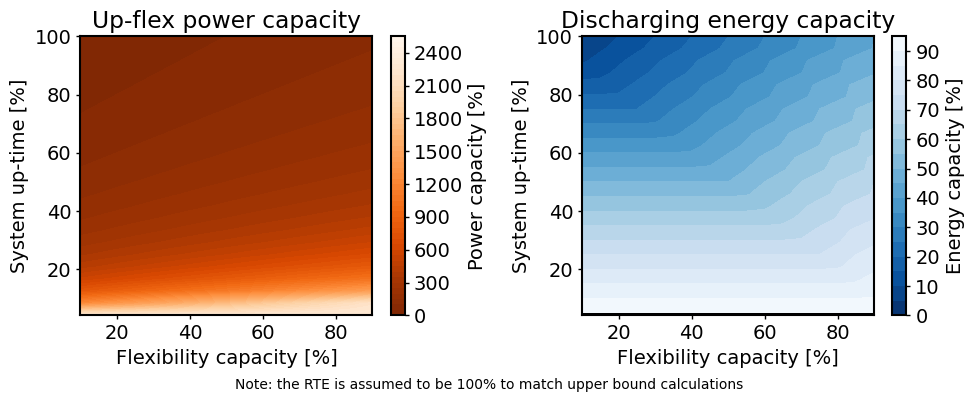

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

cs0 = ax[0].contourf(flex_capacity_mesh*100, 100 * min_onsteps_mesh / max(min_onsteps_arr),  upflex_pc*100, levels=np.arange(0,2600,50),vmin=0,cmap='Oranges_r')
cbar0 = fig.colorbar(cs0)
cbar0.set_label('Power capacity [%]')
ax[0].set(ylabel='System up-time [%]', 
       xlabel='Flexibility capacity [%]',
       title='Up-flex power capacity',
       # xticks=np.arange(0,110,20),
       facecolor='k')

cs1 = ax[1].contourf(flex_capacity_mesh*100, 100 * min_onsteps_mesh / max(min_onsteps_arr), discharge_ec*100, levels=np.arange(0,100,5), vmin=0,cmap='Blues_r')
cbar1 = fig.colorbar(cs1)
cbar1.set_label('Energy capacity [%]')
ax[1].set(ylabel='System up-time [%]', 
       xlabel='Flexibility capacity [%]',
       title='Discharging energy capacity',
       # xticks=np.arange(0,110,20),
       facecolor='k')

# create a note below the plot to explain the colorbar
fig.text(0.5, 0.01, 'Note: the RTE is assumed to be 100% to match upper bound calculations', ha='center', va='center', fontsize=10)

fig.tight_layout()

In [41]:
month_arr = np.arange(1, 13)
regions = ["SPP", "CAISO", "ERCOT", "PJM","ISONE", "NYISO",  "MISO"]
regional_emissions_savings_month = np.zeros((len(regions), len(month_arr)))
regional_cost_savings_month = np.zeros((len(regions), len(month_arr)))
for reg in regions:
    # calculate the max potential emissions for each month
    data = pd.read_csv('~/electricity-carbon-cost/data/average_MEFs/'+reg+'emissions.csv')
    data_costs = pd.read_csv('~/electricity-carbon-cost/data/average_LMPs/'+reg+'costs.csv')

    for i in range(len(month_arr)):
        co2i = data[data['month'] == month_arr[i]]['co2_eq_kg_per_MWh']
        flex = flexloadMILP(baseload=baseload_flat, 
                    pricesignal=co2i.tolist(), 
                    flex_capacity=0.0, 
                    rte=1.0, 
                    min_onsteps=1,
                    min_shutdowns=None)
        flex.build()
        flex.solve()
        regional_emissions_savings_month[regions.index(reg), i] = flex.model.pct_savings()

        try:
            lmp= data_costs[data_costs['month'] == month_arr[i]]['USD_per_MWh']
            flex = flexloadMILP(baseload=baseload_flat, 
                        pricesignal=lmp.tolist(), 
                        flex_capacity=0.0, 
                        rte=1.0, 
                        min_onsteps=1,
                        min_shutdowns=None)
            flex.build()
            flex.solve()
            regional_cost_savings_month[regions.index(reg), i] = flex.model.pct_savings()
        except:
            # regional_cost_savings_month[regions.index(reg), i] = np.nan
            pass



In [42]:
# drop all nans
regional_cost_savings_month[regions.index('MISO'), :]
# regional_emissions_savings_month[regions.index('MISO'), :]


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 28.84540209,
       23.52983118, 23.48145975])

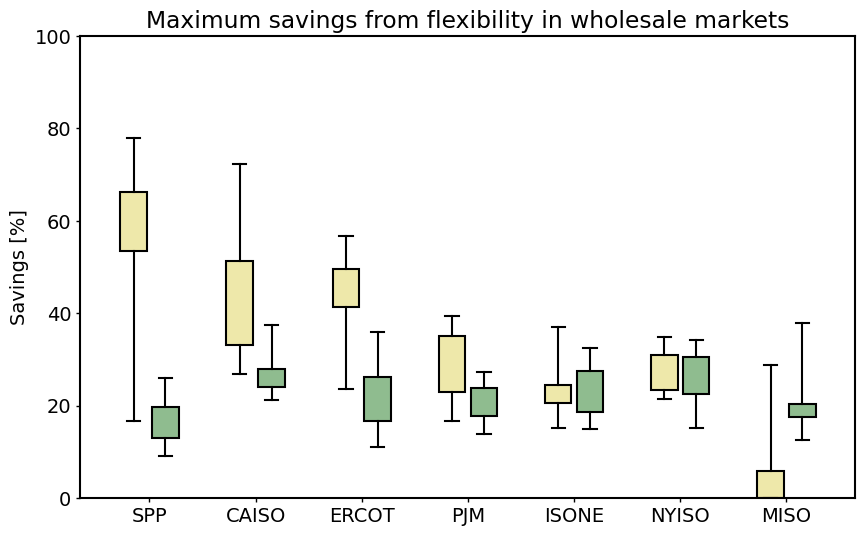

In [44]:
# create a plot of the emissions savings
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(regional_emissions_savings_month.T, 
              positions=np.arange(len(regions))+0.15,
              widths = 0.25,
              labels=regions, 
              patch_artist=True,
              showfliers=False,
              whis=(0, 100),
              medianprops={'linewidth': 0},
              boxprops={'linewidth': 1.5, 'facecolor': 'darkseagreen'},
              whiskerprops={'linewidth': 1.5},
              capprops={'linewidth': 1.5})

# TODO Uncomment when LMPs are added
ax.boxplot(regional_cost_savings_month.T, 
              positions=np.arange(len(regions))-0.15,
              widths = 0.25,
              labels=regions, 
              patch_artist=True,
              showfliers=False,
              whis=(0, 100),
              medianprops={'linewidth': 0},
              boxprops={'linewidth': 1.5, 'facecolor': 'palegoldenrod'},
              whiskerprops={'linewidth': 1.5},
              capprops={'linewidth': 1.5})

ax.set(#xlabel='Region', 
       ylabel='Savings [%]',
       title='Maximum savings from flexibility in wholesale markets',
       ylim=(0, 100),
       xticks=np.arange(len(regions)))

plt.show()


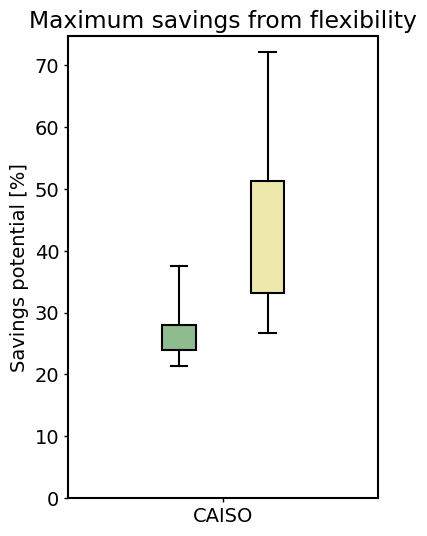

In [ ]:
month_arr = np.arange(1, 13)
regional_emissions_savings_month = np.zeros((1, len(month_arr)))
regional_cost_savings_month = np.zeros((1, len(month_arr)))
reg = 'CAISO'    # calculate the max potential emissions for each month
data = pd.read_csv('~/electricity-carbon-cost/data/average_MEFs/'+reg+'emissions.csv')
data_costs = pd.read_csv('~/electricity-carbon-cost/data/average_LMPs/'+reg+'costs.csv')
for i in range(len(month_arr)):
    co2i = data[data['month'] == month_arr[i]]['co2_eq_kg_per_MWh']
    lmp = data_costs[data_costs['month'] == month_arr[i]]['USD_per_MWh']

    flex = flexloadMILP(baseload=baseload_flat, 
                pricesignal=co2i.tolist(), 
                flex_capacity=0.0, 
                rte=1.0, 
                min_onsteps=1,
                min_shutdowns=None)
    flex.build()
    flex.solve()
    regional_emissions_savings_month[regions.index(reg), i] = flex.model.pct_savings()

    flex = flexloadMILP(baseload=baseload_flat, 
                pricesignal=lmp.tolist(), 
                flex_capacity=0.0, 
                rte=1.0, 
                min_onsteps=1,
                min_shutdowns=None)
    flex.build()
    flex.solve()
    regional_cost_savings_month[regions.index(reg), i] = flex.model.pct_savings()

# create a plot of the emissions savings
fig, ax = plt.subplots(figsize=(4,6))
ax.boxplot(regional_emissions_savings_month.T, 
              positions= [0.8],
            #   widths = 0.25,
              labels=['CAISO'], 
              patch_artist=True,
              showfliers=False,
              whis=(0, 100),
              medianprops={'linewidth': 0},
              boxprops={'linewidth': 1.5, 'facecolor': 'darkseagreen'},
              whiskerprops={'linewidth': 1.5},
              capprops={'linewidth': 1.5})

ax.boxplot(regional_cost_savings_month.T, 
              positions=[1.2],
            #   widths = 0.25,
              labels=["CAISO"], 
              patch_artist=True,
              showfliers=False,
              whis=(0, 100),
              medianprops={'linewidth': 0},
              boxprops={'linewidth': 1.5, 'facecolor': 'palegoldenrod'},
              whiskerprops={'linewidth': 1.5},
              capprops={'linewidth': 1.5})

ax.set(
       ylabel='Savings potential [%]',
       title='Maximum savings from flexibility',
       ylim=(0, None),
       xticks=[1])

plt.show()



In [ ]:
# create pareto curve for the cost/emissions savings
operational_cases = ['Upper Limit',  '25% uptime, 0% flex', '50% uptime-50% flex', '100% uptime-25% flex']
flex_capacity = [0.0, 0.0, 0.5, 0.25]
min_onsteps = [1, 6, 12, 24]
min_shutdowns = [1]

regions = ["CAISO", "ERCOT", "PJM","ISONE", "NYISO"]
# regions=["ERCOT"]
regional_results = {}
for reg in regions:
    data_mef = pd.read_csv('~/electricity-carbon-cost/data/average_MEFs/'+reg+'emissions.csv')
    data_lmp = pd.read_csv('~/electricity-carbon-cost/data/average_LMPs/'+reg+'costs.csv')

    results = {}

    for idx in range(len(operational_cases)):
        shadow_prices = []
        for month in np.arange(1,13,1):
            mef = data_mef[data_mef['month'] == month]['co2_eq_kg_per_MWh']
            lmp = data_lmp[data_lmp['month'] == month]['USD_per_MWh']

            # baseline case 
            base_cost = sum(baseload_flat * lmp)
            base_emissions = sum(baseload_flat * mef)

            # cost optimal case
            flex = flexloadMILP(baseload=baseload_flat,
                                pricesignal=lmp.tolist(),
                                flex_capacity=flex_capacity[idx],
                                rte=1.0,
                                min_onsteps=min_onsteps[idx],
                                min_shutdowns=1)
            flex.build()
            flex.solve()
            load = np.array([flex.model.flexload[i]() for i in flex.model.flexload])
            cost_optimal_delta_cost = base_cost - sum(load*lmp)
            cost_optimal_delta_emissions = base_emissions - sum(load * mef)

            # emissions optimal case
            flex = flexloadMILP(baseload=baseload_flat,
                                pricesignal=mef.tolist(),
                                flex_capacity=flex_capacity[idx],
                                rte=1.0,
                                min_onsteps=min_onsteps[idx],
                                min_shutdowns=1)
            flex.build()
            flex.solve()
            load = np.array([flex.model.flexload[i]() for i in flex.model.flexload])
            emissions_optimal_delta_cost = base_cost - sum(load*lmp)
            emissions_optimal_delta_emissions = base_emissions - sum(load * mef)

            # shadow price of carbon
            tmp_sp = (1e-12) -(cost_optimal_delta_cost - emissions_optimal_delta_cost )/ (cost_optimal_delta_emissions - emissions_optimal_delta_emissions + 1e-12)
            shadow_prices.append(tmp_sp)
        results[operational_cases[idx]] = shadow_prices
    regional_results[reg] = results




In [ ]:
regional_results["ERCOT"]['Upper Limit']

[0.15142677225823756,
 13.336316811936632,
 0.03279395153166746,
 0.029074950272630712,
 0.04665316077153407,
 0.009585050486924858,
 0.0351941569195642,
 0.019787516378692166,
 0.014280587571499033,
 0.011482449740474942,
 1.1236705746079847,
 0.16998973476997367]

In [ ]:
regional_results_processed = {}

for r in regions:
    results_processed = {}
    for key in regional_results[r].keys():
        max_val = max(regional_results[r][key])
        min_val = min(regional_results[r][key])
        results_processed[key] = {'height': max_val-min_val, 'min': min_val}
    regional_results_processed[r] = results_processed
# results_processed = {}
# for key in results.keys():
#     max_val = max(results[key])
#     min_val = min(results[key])
#     results_processed[key] = {'height': max_val-min_val, 'min': min_val}

In [ ]:
regional_results_processed

{'CAISO': {'Upper Limit': {'height': 0.9394157304164902, 'min': 1e-12},
  '25% uptime, 0% flex': {'height': 1.32276750766282,
   'min': 0.06900776203659033},
  '50% uptime-50% flex': {'height': 0.5943068820835951,
   'min': 0.18288204178399234},
  '100% uptime-25% flex': {'height': 0.3529198845669965,
   'min': 0.1998448878467254}},
 'ERCOT': {'Upper Limit': {'height': 13.326731761449707,
   'min': 0.009585050486924858},
  '25% uptime, 0% flex': {'height': 11.618391367129489,
   'min': 0.09572212308020565},
  '50% uptime-50% flex': {'height': 5.058940312051962,
   'min': 0.0744129705418663},
  '100% uptime-25% flex': {'height': 3.6632428282425806,
   'min': 0.08120955265359124}},
 'PJM': {'Upper Limit': {'height': 1.030286764113362, 'min': 1e-12},
  '25% uptime, 0% flex': {'height': 0.9601163880045543, 'min': 1e-12},
  '50% uptime-50% flex': {'height': 0.27703737906044934,
   'min': 0.050222148931171634},
  '100% uptime-25% flex': {'height': 0.34830421062230793,
   'min': 0.05991998055

In [ ]:
enumerate(regional_results_processed["ERCOT"].keys())

[Text(0, 0.5, 'Cost [$/ton]'),
 Text(0.5, 1.0, 'Cost of emissions abatement in wholesale markets'),
 None,
 (0.01, 100000.0)]

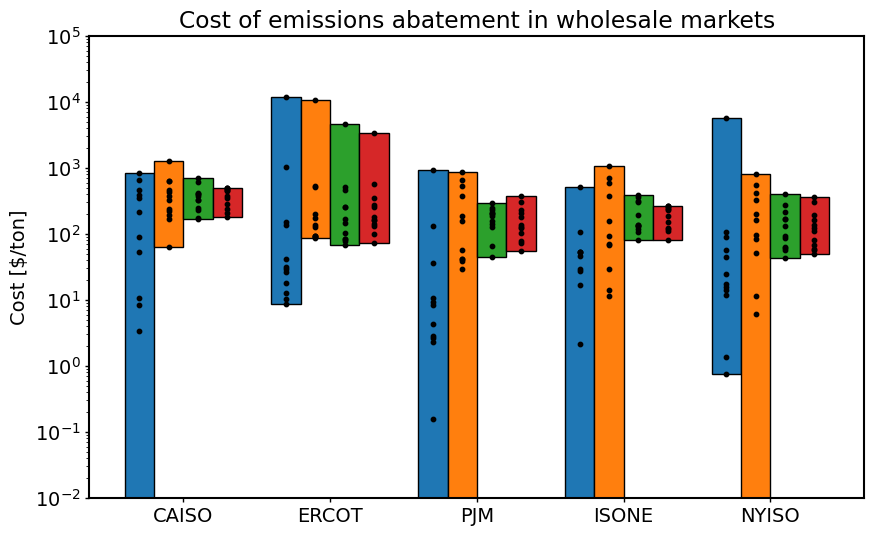

In [ ]:
# plot results dict where each key is a grouped bar and the bar should represent the range of shadow prices
fig, ax = plt.subplots(figsize=(10,6))
barWidth = 0.2
r = len(regions)
pos = [-barWidth*1.5, -barWidth/2, barWidth/2, barWidth*1.5]
cols = ['C0', 'C1', 'C2', 'C3']

for r in range(len(regions)):
    reg = regions[r]
    for idx, key in enumerate(regional_results_processed[reg].keys()):
        ax.bar(r + pos[idx], height=np.array(regional_results_processed[reg][key]['height']) * 907.185, bottom=np.array(regional_results_processed[reg][key]['min'])*907.185, width=barWidth, label=key, color=cols[idx], edgecolor='k')
        ax.scatter((r + pos[idx])*np.ones(len(regional_results[reg][key])), np.array(regional_results[reg][key])*907.185, color='k', s=10)

# for r in range(len(regions)):
#     for idx, key in enumerate(regional_results_processed[reg].keys()):
#         ax.bar(r + pos[idx], height=regional_results_processed[reg][key]['height'], bottom=regional_results_processed[reg][key]['min'], width=barWidth, label=key, color=cols[idx])
#         ax.scatter((r + pos[idx])*np.ones(len(regional_results[reg][key])), regional_results[reg][key], color='k', s=10)

# set the xtick to be at 1 and th elable to be the region
ax.set_xticks(range(len(regions)))
ax.set_xticklabels(regions)

ax.set(ylabel='Cost [$/ton]', 
       title='Cost of emissions abatement in wholesale markets',
       yscale='log',
       ylim=(1e-2, 1e5))